In [1]:
from glob import glob

import os

In [2]:
train_path = os.path.normpath("dataset/train")

In [3]:
for dirname in os.listdir(train_path):
    hex_str = dirname.replace('#U', '\\U0000')
    print(hex_str)
    print(hex_str.encode().decode('unicode-escape'))

면불량
ë©´ë¶ë
울음
ì¸ì
이음부불량
ì´ìë¶ë¶ë
터짐
í°ì§
석고수정
ìê³ ìì 
틈새과다
íìê³¼ë¤
훼손
í¼ì
꼬임
ê¼¬ì
곰팡이
ê³°í¡ì´
가구수정
ê°êµ¬ìì 
피스
í¼ì¤
들뜸
ë¤ë¸
창틀,문틀수정
ì°½í,ë¬¸íìì 
녹오염
ë¹ì¤ì¼
걸레받이수정
ê±¸ë ë°ì´ìì 
오타공
ì¤íê³µ
몰딩수정
ëª°ë©ìì 
오염
ì¤ì¼
반점
ë°ì 


In [4]:
import pandas as pd
import glob

In [5]:
all_img_list = glob.glob('./dataset/train/*/*')

df = pd.DataFrame(columns=['img_path', 'label'])
df['img_path'] = all_img_list
df['label'] = df['img_path'].apply(lambda x : str(x).split('/')[-2])

In [6]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

train_ds, val_ds, _, _ = train_test_split(df, df['label'], test_size=0.3, stratify=df['label'], random_state=42)

le = preprocessing.LabelEncoder()
train_ds['label'] = le.fit_transform(train_ds['label'])
val_ds['label'] = le.transform(val_ds['label'])

/opt/conda/envs/mlenv/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
<ipython-input-6-207547454190>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_ds['label'] = le.fit_transform(train_ds['label'])
<ipython-input-6-207547454190>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_ds['label'] = le.transform(val_d

In [7]:
import cv2
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

In [8]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, transforms=None):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.transforms = transforms
        
    def __getitem__(self, index):
        img_path = self.img_path_list[index]
        
        image = cv2.imread(img_path)
        
        if self.transforms is not None:
            image = self.transforms(image=image)['image']
        
        if self.label_list is not None:
            label = self.label_list[index]
            return image, label
        else:
            return image
        
    def __len__(self):
        return len(self.img_path_list)

In [9]:
val_ds['label']

2244    14
1894     3
3141    10
2266     4
673     18
        ..
3204    10
3008    10
2767     7
2846     7
2745     7
Name: label, Length: 1038, dtype: int64

In [10]:
ds = CustomDataset(train_ds['img_path'], train_ds['label'])

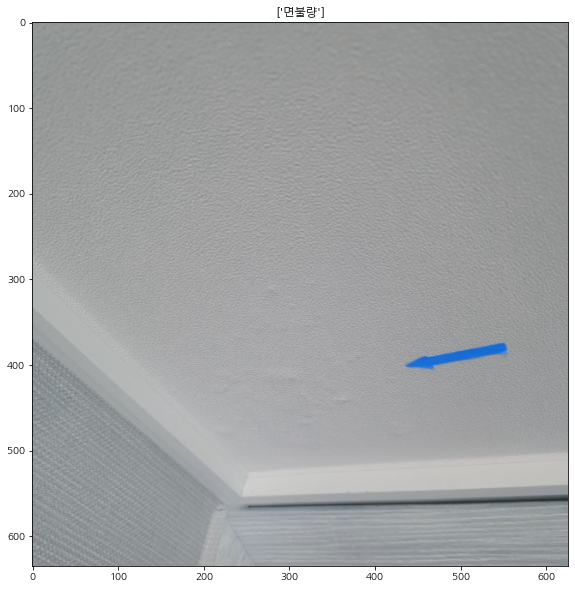

In [11]:
img_idx = 0
plt.figure(figsize=(10, 10))
plt.rc('font', family='NanumGothic')
plt.title(le.inverse_transform([ds[img_idx][1]]))
plt.imshow(ds[img_idx][0])

In [12]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [26]:
train_transform = A.Compose([
                            A.Resize(224, 224),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

test_transform = A.Compose([
                            A.Resize(224, 224),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

train_dataset = CustomDataset(train_ds['img_path'].values, train_ds['label'].values, train_transform)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle=False, num_workers=4)

val_dataset = CustomDataset(val_ds['img_path'].values, val_ds['label'].values, test_transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

In [27]:
import torch
from torch import nn
from tqdm import tqdm
import numpy as np
from sklearn.metrics import f1_score

In [28]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    
    best_score = 0
    best_model = None
    
    for epoch in range(1, 10+1):
        model.train()
        train_loss = []
        for imgs, labels in tqdm(iter(train_loader)):
            imgs = imgs.float().to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            output = model(imgs)
            loss = criterion(output, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
                    
        _val_loss, _val_score = validation(model, criterion, val_loader, device)
        _train_loss = np.mean(train_loss)
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val Weighted F1 Score : [{_val_score:.5f}]')
       
        if scheduler is not None:
            scheduler.step(_val_score)
            
        if best_score < _val_score:
            best_score = _val_score
            best_model = model
    
    return best_model

In [29]:
def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss = []
    preds, true_labels = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(iter(val_loader)):
            imgs = imgs.float().to(device)
            labels = labels.to(device)
            
            pred = model(imgs)
            
            loss = criterion(pred, labels)
            
            preds += pred.argmax(1).detach().cpu().numpy().tolist()
            true_labels += labels.detach().cpu().numpy().tolist()
            
            val_loss.append(loss.item())
        
        _val_loss = np.mean(val_loss)
        _val_score = f1_score(true_labels, preds, average='weighted')
    
    return _val_loss, _val_score

In [30]:
import timm

In [31]:
model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=19)
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, threshold_mode='abs', min_lr=1e-8, verbose=True)

infer_model = train(model, optimizer, train_loader, val_loader, scheduler, "cuda")

100%|██████████| 33/33 [00:04<00:00,  7.97it/s]

Epoch [1], Train Loss : [1.70929] Val Loss : [1.09111] Val Weighted F1 Score : [0.64614]



100%|██████████| 33/33 [00:04<00:00,  8.00it/s]

Epoch [2], Train Loss : [0.16731] Val Loss : [1.00997] Val Weighted F1 Score : [0.69853]



100%|██████████| 33/33 [00:04<00:00,  7.91it/s]

Epoch [3], Train Loss : [0.01632] Val Loss : [1.03799] Val Weighted F1 Score : [0.69989]



100%|██████████| 33/33 [00:04<00:00,  7.92it/s]

Epoch [4], Train Loss : [0.00579] Val Loss : [1.05987] Val Weighted F1 Score : [0.70110]



100%|██████████| 33/33 [00:04<00:00,  7.96it/s]

Epoch [5], Train Loss : [0.00373] Val Loss : [1.07388] Val Weighted F1 Score : [0.70550]



100%|██████████| 33/33 [00:04<00:00,  8.00it/s]

Epoch [6], Train Loss : [0.00276] Val Loss : [1.08776] Val Weighted F1 Score : [0.70588]



100%|██████████| 33/33 [00:04<00:00,  7.92it/s]

Epoch [7], Train Loss : [0.00214] Val Loss : [1.10042] Val Weighted F1 Score : [0.70782]



100%|██████████| 33/33 [00:04<00:00,  8.08it/s]

Epoch [8], Train Loss : [0.00172] Val Loss : [1.11207] Val Weighted F1 Score : [0.70666]



100%|██████████| 33/33 [00:04<00:00,  7.94it/s]

Epoch [9], Train Loss : [0.00142] Val Loss : [1.12290] Val Weighted F1 Score : [0.70666]



100%|██████████| 33/33 [00:04<00:00,  7.87it/s]

Epoch [10], Train Loss : [0.00119] Val Loss : [1.13303] Val Weighted F1 Score : [0.70699]
Epoch    10: reducing learning rate of group 0 to 1.5000e-04.


In [50]:
test = pd.read_csv('./test.csv')

def expand_path(path_dir):
    path_dir = path_dir.replace('./', './dataset/')
    return path_dir

test['img_path'] = test['img_path'].apply(expand_path)

test_dataset = CustomDataset(test['img_path'].values, None, test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

In [52]:
def inference(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for imgs in tqdm(iter(test_loader)):
            imgs = imgs.float().to(device)
            
            pred = model(imgs)
            
            preds += pred.argmax(1).detach().cpu().numpy().tolist()
    
    preds = le.inverse_transform(preds)
    return preds

preds = inference(infer_model, test_loader, "cuda")

submit = pd.read_csv('./sample_submission.csv')

submit['label'] = preds

submit.to_csv('./baseline_submit.csv', index=False)

100%|██████████| 25/25 [00:12<00:00,  2.01it/s]
